# Creating layouts by programming KLayout in Python
This tutorial is based on an open source application for creating layouts (KLayout), and open source set of helper scripts in Python (SiEPIC-Tools), and an open source Process Design Kit (PDK) with technology files (SiEPIC-EBeam-PDK).

Note this notebook is for educational purposes. Copy and paste the necessary code segments into your own Python project, using your favourite development environment, e.g., VSCode, Spyder, Jupyter notebook, KLayout's embedded Python, etc.

### Software installation:

***KLayout***

> pip install klayout

***SiEPIC-Tools***

> pip install SiEPIC

***SiEPIC-EBeam PDK***

> pip install siepic_ebeam_pdk



In [ ]:
!pip install klayout --upgrade
!pip install SiEPIC  --upgrade
!pip install siepic_ebeam_pdk  --upgrade

# Tutorial

### Create a new layout
 - technology: EBeam
 - top cell name: Top
 - floor plan dimensions: 605,000 x 410,000 nm = 605 x 410 µm
 - database units (1 unit = 0.001 micron = 1 nm, configured in the EBeam technology)

In [1]:
import pya # KLayout Python API
import SiEPIC  # import module for SiEPIC-Tools, helper functions for KLayout
import siepic_ebeam_pdk  # import module for the SiEPIC-EBeam-PDK technology
from SiEPIC.utils.layout import new_layout, floorplan

tech_name, top_cell_name = 'EBeam', 'Top'
topcell, ly = new_layout(tech_name, top_cell_name, GUI=True, overwrite = True)
floorplan(topcell, 605e3, 410e3)
dbu = ly.dbu

KLayout SiEPIC-Tools version 0.5.28
SiEPIC-Tools is up to date (0.5.28 vs 0.5.28).
Version check, time: 0.20283007621765137 seconds
SiEPIC-EBeam-PDK Python module: siepic_ebeam_pdk, KLayout technology: EBeam
SiEPIC-EBeam-PDK Python module: pymacros, v0.4.47
Libraries associated with Technology EBeam: ['EBeam', 'EBeam-ANT', 'EBeam-Dream', 'EBeam-SiN', 'EBeam_Beta']


### Create a blank cell in the layout
- name: cell
- Instantiate it as a subcell of the top cell at position (0,0) database units
- record the instance in a variable (inst_cell) so we can manipulate or query it later if necessary

In [5]:
import pya  # import module for KLayout

subcell = ly.create_cell('cell')
t = pya.Trans(pya.Trans.R0, 0,0)
inst_cell = topcell.insert(pya.CellInstArray(subcell.cell_index(), t))

### Place cells from the PDK
- use SiEPIC create_cell2 function, which is an enhanced version (error checking) of pya.Layout.create_cell
- Instantiate it in the subcell at position (40 µm, 15 µm) or (40e3, 15e3) database units
- record the instance in a variable (inst_gc1) so we can manipulate or query it later if necessary

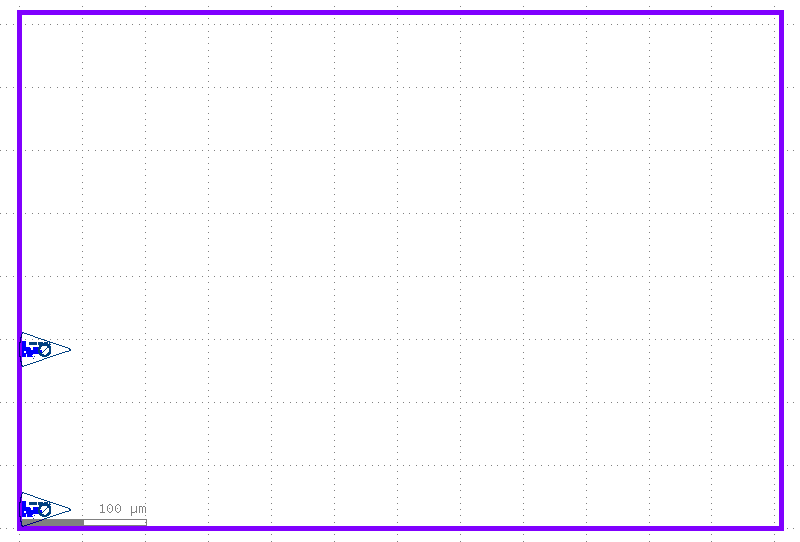

In [6]:
from SiEPIC.utils import create_cell2
cell = create_cell2(ly, 'GC_TE_1310_8degOxide_BB', 'EBeam')
t = pya.Trans(pya.Trans.R0, 40e3,15e3)
inst_gc1 = topcell.insert(pya.CellInstArray(cell.cell_index(), t))

t = pya.Trans(pya.Trans.R0, 40e3,15e3+127e3)
inst_gc2 = topcell.insert(pya.CellInstArray(cell.cell_index(), t))

cell.plot(width = 400)
topcell.plot(width = 400)

## Components and their pins
- Query a cell to get the SiEPIC Component description
- Get the pins associated with this Component
- Alternative: Query a cell to get a list of Pins

In [7]:

print('Display component details:')
component = cell.find_components()[0]  # find component within a cell, return the first one
print(type(component))
component.display()

print('\nDisplay pin details:')
pins = cell.find_pins_component(component)
for p in pins:
    p.display()
    
# or only pins
print('\nDisplay pin names:')
pins, _ = cell.find_pins()
for p in pins:
    if p.type == 1:  # optical pin type, defined in SiEPIC._globals
        print(' - ', p.pin_name)

Display component details:
<class 'SiEPIC.core.Component'>
- basic_name: GC_TE_1310_8degOxide_BB, component: GC_TE_1310_8degOxide_BB-0 / GC_TE_1310_8degOxide_BB; transformation: r0 *1 0,0; center position: -19.985,0.084; number of pins: 2; optical pins: [['opt1', '0,0', None]]; electrical pins: []; optical IO pins: [['GC_TE_1310_8degOxide_BB', '-20400,0', None]]; has compact model: False; params: .

Display pin details:
- pin_name opt1: component_idx 0, pin_type 1, rotation: 0.0, net: None, (0,0), path: (-10,0;10,0) w=350 bx=0 ex=0 r=false
- pin_name GC_TE_1310_8degOxide_BB: component_idx 0, pin_type 0, rotation: 0, net: None, (-20400,0), path: None

Display pin names:
 -  opt1


## Waveguides
- Find out what types of waveguides are defined in the PDK
- Connect two components using a waveguide
- Specify the waveguide type
- Specify the path the waveguide should take
- Return the wavelength details (length)

In [ ]:
from SiEPIC.utils import load_Waveguides_by_Tech
waveguide_types = load_Waveguides_by_Tech(tech_name)

print('Waveguide types:')
for w in waveguide_types:
    print('  %s' % w['name'])
wg_type = waveguide_types[0]['name']

from SiEPIC.scripts import connect_pins_with_waveguide
wg = connect_pins_with_waveguide(inst_gc1, 'opt1', inst_gc2, 'opt1', 
                                    turtle_A=[5, -90, 
                                              20, 90, 10, 90, 1, 90],
                                    waveguide_type=wg_type,
                                )

from SiEPIC.utils import waveguide_length
print(waveguide_length(wg))

topcell.plot() # in the browser
topcell.show() # in KLayout GUI
        

Waveguide types:
  Strip TE 1550 nm, w=500 nm
  Strip TE 1550 nm, w=500 nm, r=10
  Strip TE 1310 nm, w=410 nm
  Strip TE 1310 nm, w=350 nm
  Strip TM 1550 nm, w=500 nm
  Strip TE-TM 1550, w=450 nm
  Multimode Strip TE 1550 nm, w=2000 nm
  Multimode Strip TE 1550 nm, w=3000 nm
  Slot TE 1550 nm, w=500 nm, gap=100nm
  eskid TE 1550
  Rib (90 nm slab) TE 1550 nm, w=500 nm
  Rib (90 nm slab) TE 1310 nm, w=350 nm
  Si routing TE 1550 nm (compound waveguide)
  Si routing TE 1310 nm (compound waveguide)
  SiN Strip TE 895 nm, w=450 nm
  SiN Strip TE 1550 nm, w=750 nm
  SiN Strip TE 1550 nm, w=800 nm
  SiN Strip TE 1550 nm, w=1000 nm
  SiN Strip TM 1550 nm, w=1000 nm
  SiN Strip TE 1310 nm, w=750 nm
  SiN Strip TE 1310 nm, w=800 nm
  SiN Strip TM 1310 nm, w=750 nm
  Multimode SiN Strip TE 1550 nm, w=3000 nm
  SiN routing TE 1550 nm (compound waveguide)
190.793
Message from klive: {"version": "0.2.2", "type": "open", "file": "/var/folders/2_/hfctv7kn7h965wdl4jgrm8t80000gn/T/tmpiu1qbxpk/Top.gds"

# Instantiate a PCell

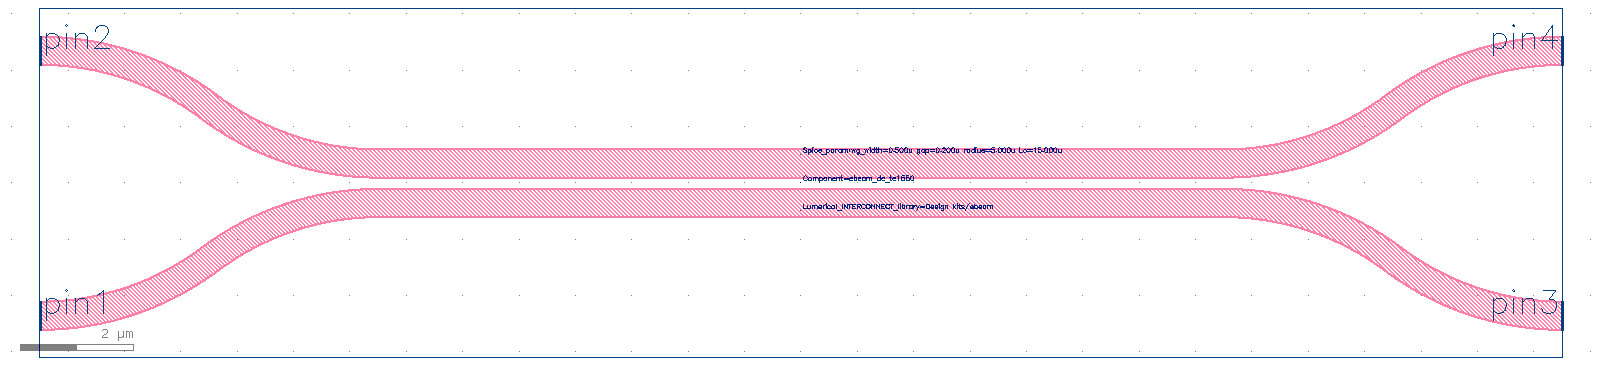

In [19]:
tech_name, top_cell_name = 'EBeam', 'Top'
topcell, ly = new_layout(tech_name, top_cell_name, GUI=True, overwrite = True)

cell = ly.create_cell('ebeam_dc_te1550', 'EBeam',
                       {'Lc':15})  # set the coupler length 
t = pya.Trans(pya.Trans.R0, 100e3,130e3)
inst_dc = topcell.insert(pya.CellInstArray(cell.cell_index(), t))

topcell.plot() # in the browser


# Connect a component

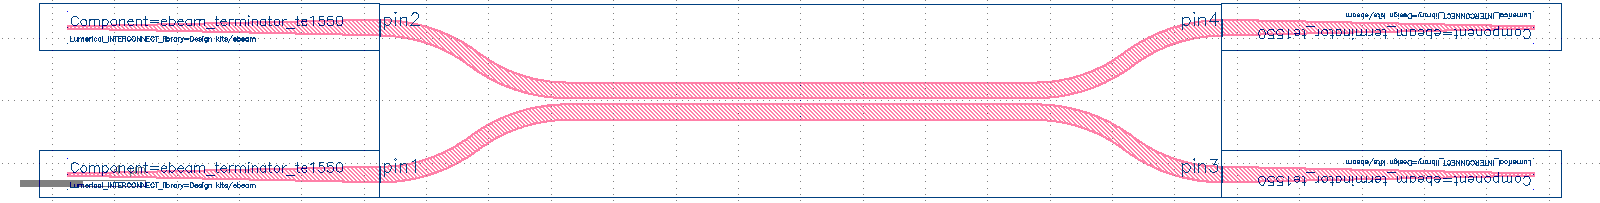

In [20]:
from SiEPIC.utils import create_cell2
cell_terminator = create_cell2(ly, 'ebeam_terminator_te1550', 'EBeam')

# Add terminators
from SiEPIC.scripts import connect_cell
connect_cell(inst_dc, 'pin1', cell_terminator, 'opt1')
connect_cell(inst_dc, 'pin2', cell_terminator, 'opt1')
connect_cell(inst_dc, 'pin3', cell_terminator, 'opt1')
connect_cell(inst_dc, 'pin4', cell_terminator, 'opt1')

topcell.plot() # in the browser


## Developers
- Install the tools and PDKs by creating a copy using GitHub Desktop, then installing as a symbolic link in pip.

In [9]:
!python -m pip install -e '/Users/lukasc/Documents/GitHub/SiEPIC-Tools/klayout_dot_config/python'
!python -m pip install -e '/Users/lukasc/Documents/GitHub/SiEPIC_EBeam_PDK/klayout'

Obtaining file:///Users/lukasc/Documents/GitHub/SiEPIC-Tools/klayout_dot_config/python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SiEPIC (pyproject.toml) ... done
  Created wheel for SiEPIC: filename=siepic-0.5.28-0.editable-py3-none-any.whl size=4497 sha256=dcea1e3df859b166b53fe21aec123a1c3c55a0ff522972b5709426724c4ffdc1
  Stored in directory: /private/var/folders/2_/hfctv7kn7h965wdl4jgrm8t80000gn/T/pip-ephem-wheel-cache-g8ruhwjn/wheels/b4/6c/1b/d9c71c76ac3927f9781889d2dae250ccb80f7745619aa177da
Successfully built SiEPIC
  Attempting uninstall: SiEPIC
    Found existing installation: SiEPIC 0.5.26
    Uninstalling SiEPIC-0.5.26:
      Successfully uninstalled SiEPIC-0.5.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the